## New York State External Appeal Data From 2019-2022

We investigate the New York State (NYS) database of external appeal decisions maintained by the NYS Department of Financial Services (DFS).

At the time of writing, the database is hosted at: https://www.dfs.ny.gov/public-appeal/search.

### Setup

In [1]:
import os
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
from datetime import datetime


pd.set_option("display.max_columns", None)
sys.path.append("../..")

from src.utils.download import download_file_from_url
from src.utils.plot import plot_bar, plot_pie, heatmap_from_df_cols

INPUT_DATA_DIR = "./input_data"
OUTPUT_IMAGE_DIR = "./images/nys_external"
OUTPUT_DATA_DIR = "./output_data/nys_external"  # Set to None if you don't want to save non-required data for external use

In [2]:
os.makedirs(INPUT_DATA_DIR, exist_ok=True)
if OUTPUT_IMAGE_DIR:
    os.makedirs(OUTPUT_IMAGE_DIR, exist_ok=True)
if OUTPUT_DATA_DIR:
    os.makedirs(OUTPUT_DATA_DIR, exist_ok=True)

### Download Raw Data

In [3]:
# URL obtained by clicking "Export" here: https://www.dfs.ny.gov/public-appeal/search
url = "https://myportal.dfs.ny.gov/peasa-dataextract-portlet/rest/dfsservices/peasaserviceexcel"
appeal_data_path = os.path.join(INPUT_DATA_DIR, "nys_external_appeal_outcomes.xlsx")
download_file_from_url(url, appeal_data_path)

Target file ./input_data/nys_external_appeal_outcomes.xlsx already exists.


### Read and Clean Data

In [4]:
df = pd.read_excel(appeal_data_path)

# Remove single 2002 record, as it appears to be accidentally included, or a typo on date
df = df[df["Decision Year"] != 2002]

# Standardize agent names
df["Agent"] = df["Agent"].apply(
    lambda x: "MCMC" if x == "MCMC Services, L.L.C." or x == "MCMC, LLC" else x
)

/home/mike/venvs/investigations/lib/python3.10/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [5]:
print(f"This dataset contains a total of {len(df)} external appeals from NY.")
for year, count in df["Decision Year"].value_counts().items():
    print(f"\t{count} external appeals from {year}")

This dataset contains a total of 26036 external appeals from NY.
	8242 external appeals from 2022
	6540 external appeals from 2021
	5816 external appeals from 2020
	4130 external appeals from 2019
	1308 external appeals from 2023


**Question**: What is the total population of _initial claims_, _initially denied claims_, and _internally appealed claims_ for each insurer/year combination documented in this external appeal database? These denominators are crucial for drawing certain conclusions from this data. Can the corresponding total pools of claims for some (or all) of the insurers documented here be extracted from existing CMS public use files?

The only places these sorts of figures partially exist, of which I am aware, are:

- NY Consumer guides (exist historically, detail appeal numbers, but not base denial numbers!)
    - e.g. https://www.dfs.ny.gov/system/files/documents/2021/08/ny_consumer_guide_health_insurers_2021.pdf
- NY claim reports (starting 2022)
    - e.g. https://www.dfs.ny.gov/reports_and_publications/health_care_claim_reports

### Helper Functions

In [6]:
def get_overturn_rates_by_category(
    df: pd.DataFrame, cat_col: str, by_year: bool = False
) -> dict:
    """Given a column in df, specified by cat_col, break down appeal decision outcomes split on distinct values in the column."""
    decision_data = {}
    for val in df[cat_col].unique():
        decision_data[val] = {}
        rel_df = df[df[cat_col] == val]
        overturn_counts = rel_df["Appeal Decision"].value_counts()
        decision_data[val]["overall"] = {}
        overturned = overturn_counts.get("Overturned", None)
        decision_data[val]["overall"]["upheld"] = overturn_counts.get("Upheld", None)
        decision_data[val]["overall"]["completely_overturned"] = overturned
        decision_data[val]["overall"]["partially_overturned"] = overturn_counts.get(
            "Overturned in Part", None
        )
        decision_data[val]["overall"]["complete_overturn_rate"] = (
            overturned / overturn_counts.values.sum() if overturned else None
        )

        if by_year:
            for year in rel_df["Decision Year"].unique():
                decision_data[val][year] = {}
                sub_df = rel_df[rel_df["Decision Year"] == year]
                overturn_counts = sub_df["Appeal Decision"].value_counts()
                overturned = overturn_counts.get("Overturned", None)
                decision_data[val][year]["upheld"] = overturn_counts.get("Upheld", None)
                decision_data[val][year]["completely_overturned"] = overturned
                decision_data[val][year]["partially_overturned"] = overturn_counts.get(
                    "Overturned in Part", None
                )
                decision_data[val][year]["complete_overturn_rate"] = (
                    overturned / overturn_counts.values.sum() if overturned else None
                )
    return decision_data

### High Level Stats

In [7]:
def print_appeal_results(appeal_decision_counts):
    bar_names, bar_vals = (
        list(appeal_decision_counts.index),
        appeal_decision_counts.values,
    )
    print(bar_names)
    print(
        f"{int(100* (round(bar_vals[0]/ bar_vals.sum(), 2)))}% of all original determinations in external appeals were upheld"
    )
    print(
        f"{int(100* (round(bar_vals[1]/ bar_vals.sum(), 2)))}% of all original determinations in external appeals were completely overturned."
    )
    print(
        f"{int(100* (round(bar_vals[2]/ bar_vals.sum(), 2)))}% of all original determinations in external appeals were partially overturned."
    )
    return None

In [8]:
appeal_decision_counts = df["Appeal Decision"].value_counts()
print_appeal_results(appeal_decision_counts)

['Upheld', 'Overturned', 'Overturned in Part']
56% of all original determinations in external appeals were upheld
43% of all original determinations in external appeals were completely overturned.
2% of all original determinations in external appeals were partially overturned.


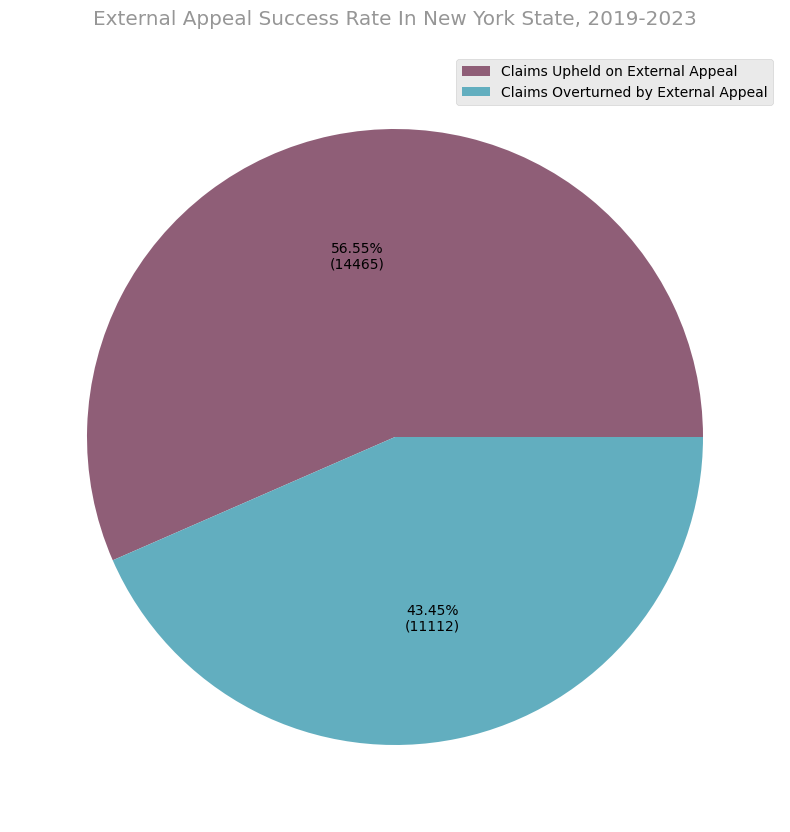

In [9]:
claims_externally_appealed = (
    appeal_decision_counts["Upheld"] + appeal_decision_counts["Overturned"]
)
claims_externally_overturned = appeal_decision_counts["Overturned"]
external_appeals_upheld = claims_externally_appealed - claims_externally_overturned
plot_pie(
    slice_names=[
        "Claims Upheld on External Appeal",
        "Claims Overturned by External Appeal",
    ],
    slice_vals=[external_appeals_upheld, claims_externally_overturned],
    title="External Appeal Success Rate In New York State, 2019-2023",
    save_path=os.path.join(OUTPUT_IMAGE_DIR, "external_appeal_success_rates.png"),
    show=True,
)

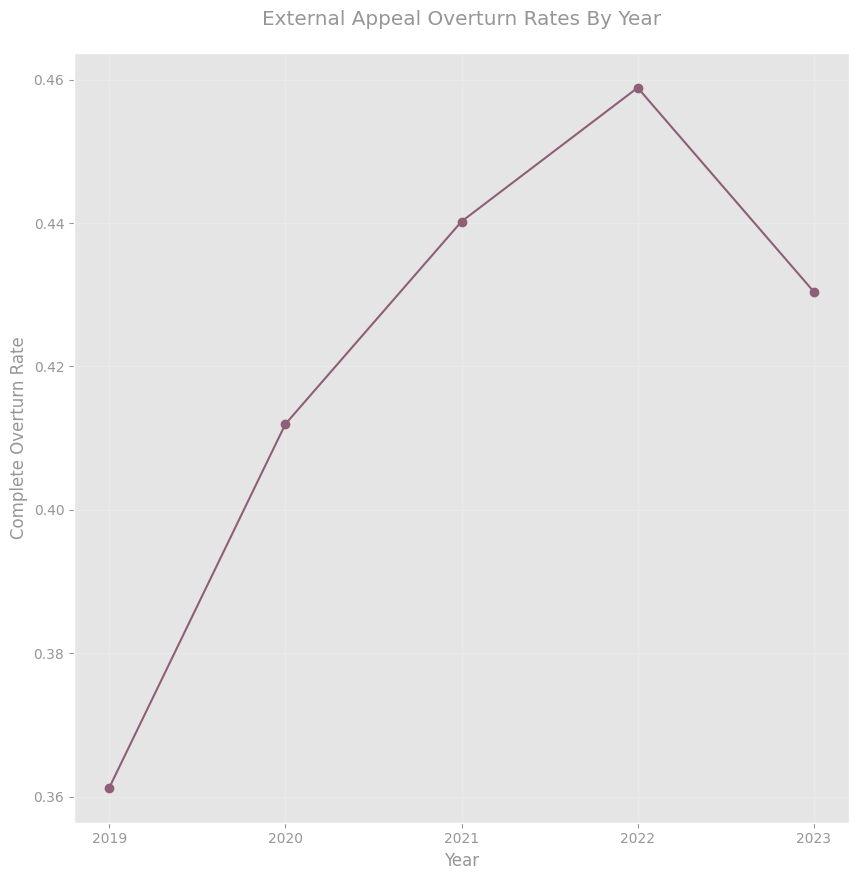

In [10]:
# Plot overall decision rates by year
decision_data = get_overturn_rates_by_category(df, "Decision Year")
fig, ax = plt.subplots(figsize=(10, 10))
x = list(df["Decision Year"].unique())
ax.set_title("External Appeal Overturn Rates By Year")
ax.set_ylabel("Complete Overturn Rate")
ax.set_xlabel("Year")
timeseries = []
for year in x:
    if decision_data.get(year, None):
        timeseries.append(decision_data[year]["overall"]["complete_overturn_rate"])
    else:
        timeseries.append(None)
dates = np.asarray(x).astype(str)
ax.plot(dates, timeseries, "o-")
save_path = os.path.join(OUTPUT_IMAGE_DIR, "external_appeal_overturn_rates_by_year.png")
plt.savefig(save_path, transparent=True, bbox_inches="tight")
plt.show()

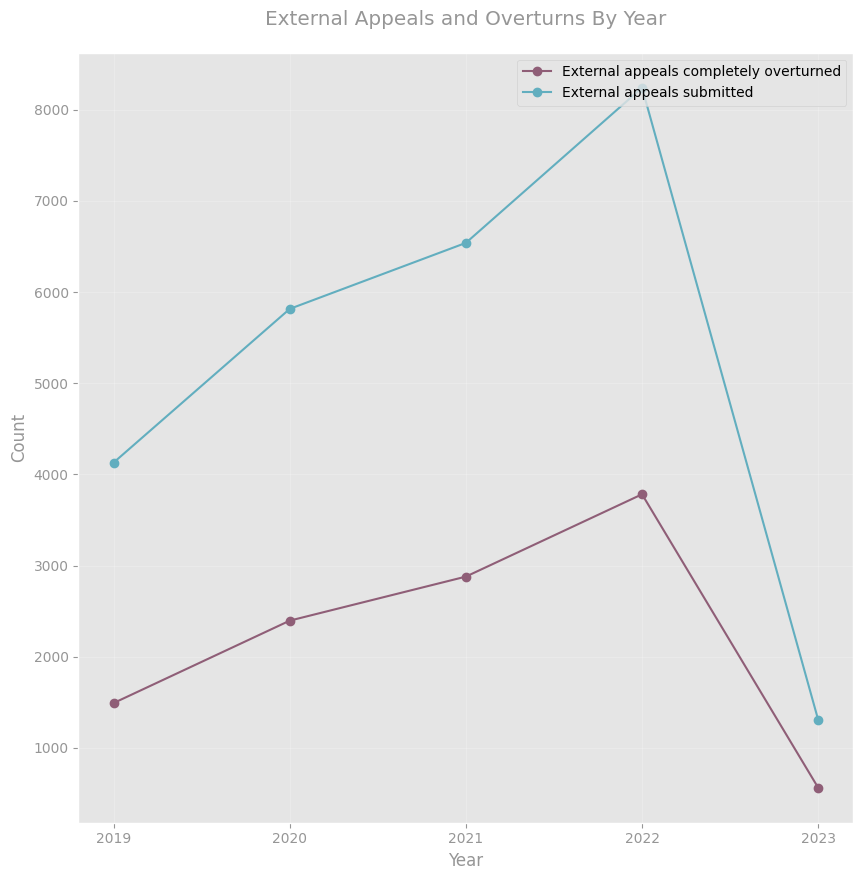

In [11]:
# Plot complete overturns and number of external appeals over same time period, to see what's affecting rate
fig, ax = plt.subplots(figsize=(10, 10))
x = list(df["Decision Year"].unique())
ax.set_title("External Appeals and Overturns By Year")
ax.set_ylabel("Count")
ax.set_xlabel("Year")
appeals_timeseries = []
overturns_timeseries = []
for year in x:
    if decision_data.get(year, None):
        year_data = decision_data[year]["overall"]
        appeals_timeseries.append(
            year_data["completely_overturned"]
            + year_data["partially_overturned"]
            + year_data["upheld"]
        )
        overturns_timeseries.append(year_data["completely_overturned"])
    else:
        appeals_timeseries.append(None)
        overturns_timeseries.append(None)
dates = np.asarray(x).astype(str)
ax.plot(
    dates, overturns_timeseries, "o-", label="External appeals completely overturned"
)
ax.plot(dates, appeals_timeseries, "o-", label="External appeals submitted")
ax.legend(labelcolor="black")
save_path = os.path.join(OUTPUT_IMAGE_DIR, "external_appeals_by_year.png")
plt.savefig(save_path, transparent=True, bbox_inches="tight")
plt.show()

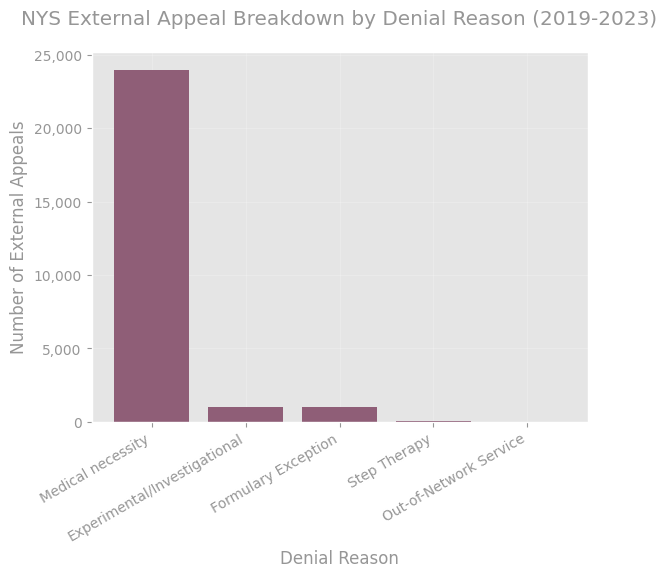

In [12]:
# Breakdown Appeals by Initial Denial Rationale
title = "NYS External Appeal Breakdown by Denial Reason (2019-2023)"
val_axis_label = "Number of External Appeals"
cat_axis_label = "Denial Reason"
denial_val_counts = df["Denial Reason"].value_counts()
bar_names, bar_vals = list(denial_val_counts.index), denial_val_counts.values
plot_bar(
    bar_names,
    bar_vals,
    title=title,
    val_axis_label=val_axis_label,
    cat_axis_label=cat_axis_label,
    save_path=os.path.join(OUTPUT_IMAGE_DIR, "external_appeals_by_denial_reason.png"),
)

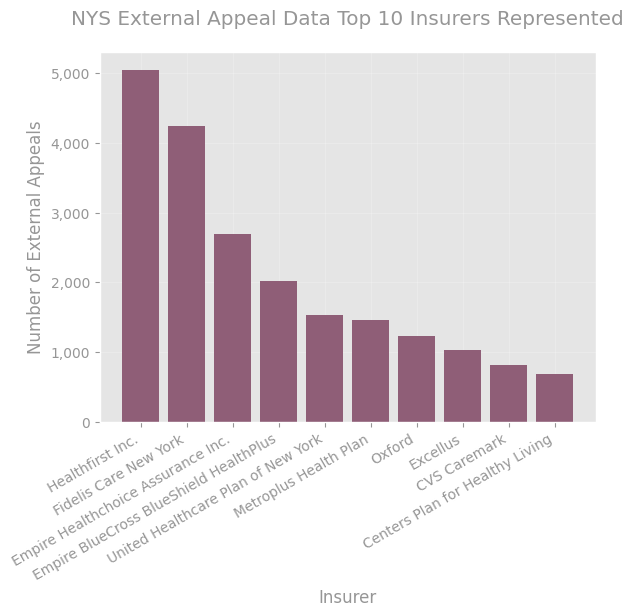

In [13]:
# Breakdown Appeals by Insurer/Issuer
title = "NYS External Appeal Data Top 10 Insurers Represented"
val_axis_label = "Number of External Appeals"
cat_axis_label = "Insurer"
val_counts = df["Health Plan"].value_counts()[:10]
bar_names, bar_vals = list(val_counts.index), val_counts.values
plot_bar(
    bar_names,
    bar_vals,
    title=title,
    val_axis_label=val_axis_label,
    cat_axis_label=cat_axis_label,
    save_path=os.path.join(OUTPUT_IMAGE_DIR, "external_appeals_top_insurers.png"),
)

**Question** As before, it'd be interesting and useful to know the relevant population counts here. E.g., external appeals for denials due to medical necessity dominate
this dataset, so we'd like to know: what is the distribution of denial rationales (for denials externally appealed, or not) among the insurers and years represented in this data?
Is this distribution of denial reasons among external appeals just following that initial denial distribution, or is there more to it than that? For example, it could be the case that consumers are more likely to externally
appeal medical necessity denials, all else equal. Or it could be the case that consumers are equally likely to appeal decisions in any category, all else equal, but insurers are more likely to overturn decisions on internal appeals
in categories other than medical necessity, leading to a higher than otherwise expected weight to the medical necessity external appeals in this data. These questions are unfortunately unanswerable from this data alone. 

#### Agent Breakdowns

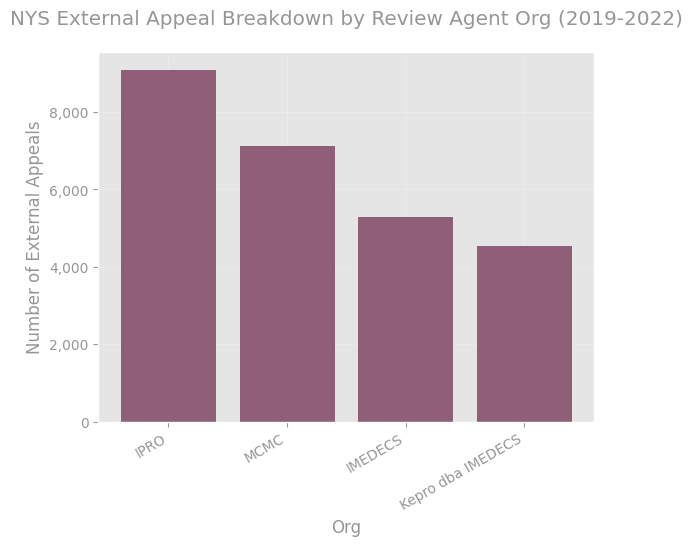

In [14]:
# Agent breakdowns
title = "NYS External Appeal Breakdown by Review Agent Org (2019-2022)"
val_axis_label = "Number of External Appeals"
cat_axis_label = "Org"
agent_val_counts = df["Agent"].value_counts()
bar_names, bar_vals = list(agent_val_counts.index), agent_val_counts.values
plot_bar(
    bar_names,
    bar_vals,
    title=title,
    val_axis_label=val_axis_label,
    cat_axis_label=cat_axis_label,
    save_path=os.path.join(OUTPUT_IMAGE_DIR, "external_appeals_by_agent.png"),
)

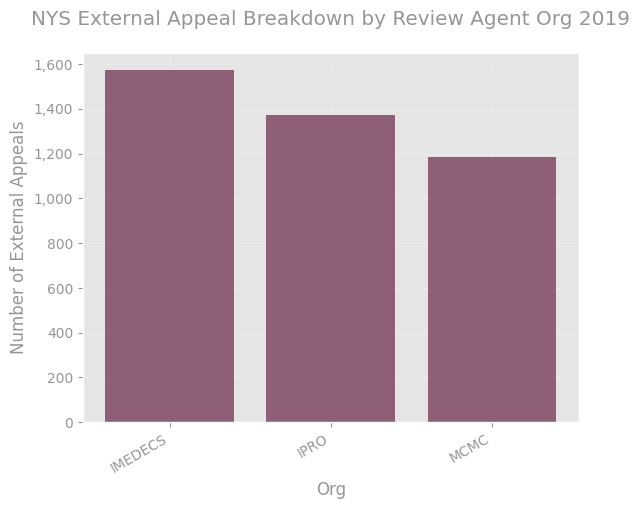

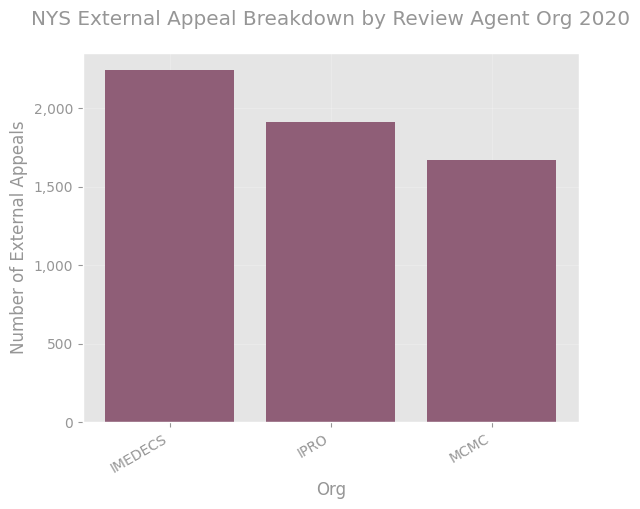

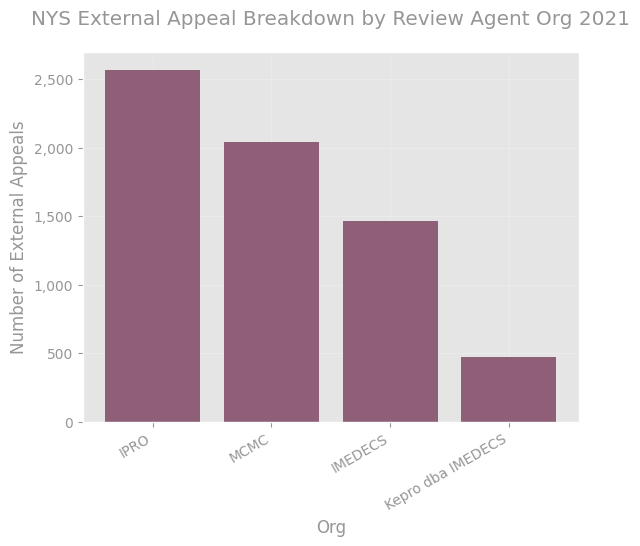

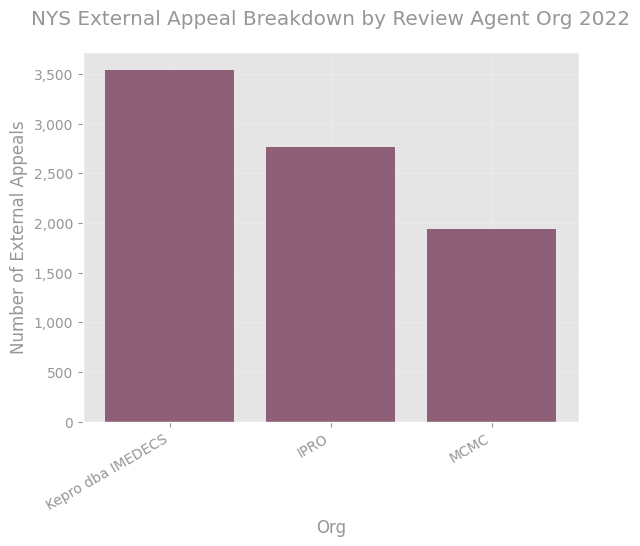

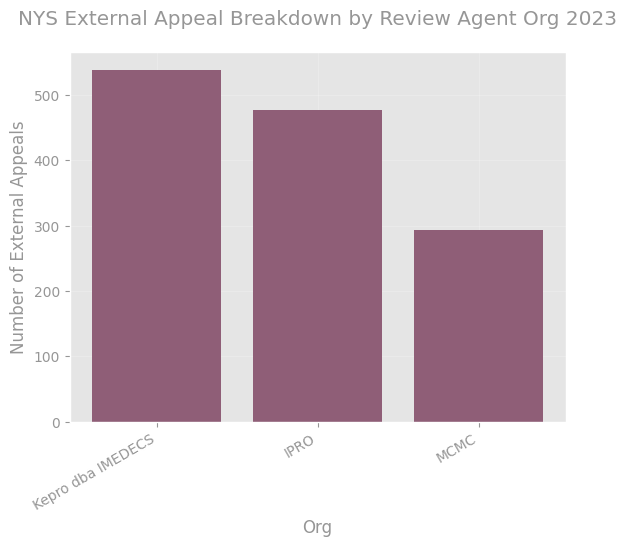

In [15]:
# Agent breakdowns by year
for year in df["Decision Year"].unique():
    rel_df = df[df["Decision Year"] == year]
    agent_val_counts = rel_df["Agent"].value_counts()
    title = f"NYS External Appeal Breakdown by Review Agent Org {year}"
    val_axis_label = "Number of External Appeals"
    cat_axis_label = "Org"
    bar_names, bar_vals = list(agent_val_counts.index), agent_val_counts.values
    plot_bar(
        bar_names,
        bar_vals,
        title=title,
        val_axis_label=val_axis_label,
        cat_axis_label=cat_axis_label,
        save_path=os.path.join(
            OUTPUT_IMAGE_DIR, f"external_appeals_by_agent_{year}.png"
        ),
    )

In [16]:
agent_decision_data = get_overturn_rates_by_category(df, cat_col="Agent", by_year=True)

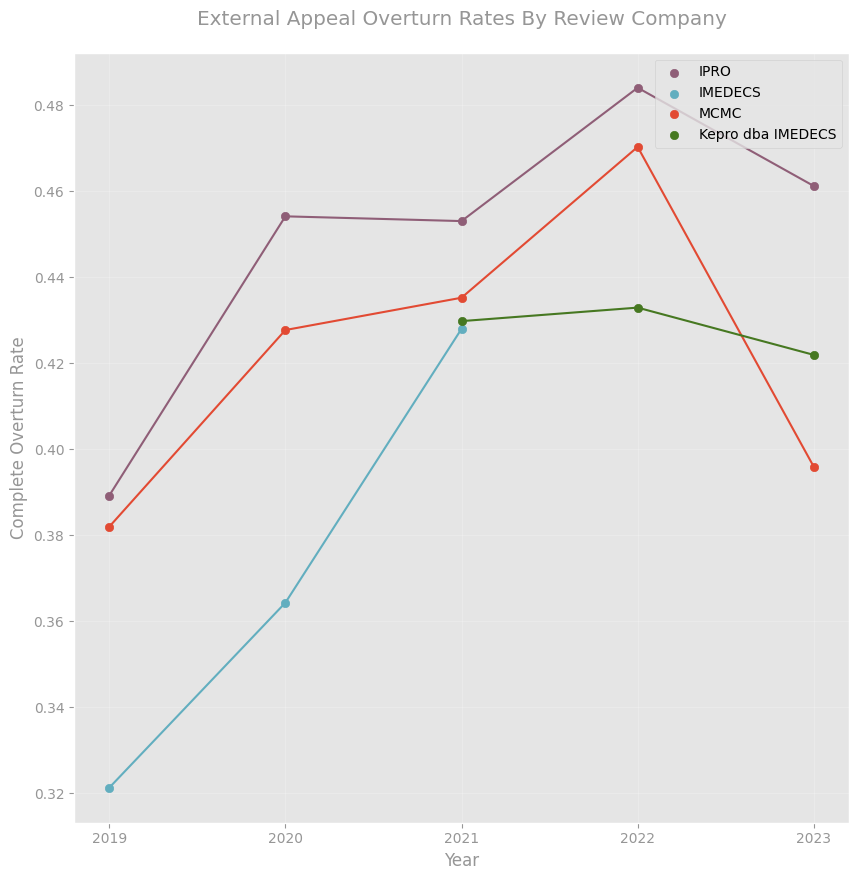

In [17]:
# Plot agent decision rates over time
fig, ax = plt.subplots(figsize=(10, 10))
x = list(df["Decision Year"].unique())
ax.set_title("External Appeal Overturn Rates By Review Company")
ax.set_ylabel("Complete Overturn Rate")
ax.set_xlabel("Year")
dates = np.asarray(x).astype(str)
for agent in agent_decision_data:
    agent_timeseries = []
    for year in x:
        if agent_decision_data[agent].get(year, None):
            agent_timeseries.append(
                agent_decision_data[agent][year]["complete_overturn_rate"]
            )
        else:
            agent_timeseries.append(None)
    ax.scatter(dates, agent_timeseries, label=agent)
    ax.plot(dates, agent_timeseries)
ax.legend(labelcolor="black")
save_path = os.path.join(
    OUTPUT_IMAGE_DIR, "external_appeal_overturn_rates_by_review_org.png"
)
plt.savefig(save_path, transparent=True, bbox_inches="tight")
plt.show()

# Seems overall overturn improvement is mostly due to IMEDECS -> Kepro acquisition

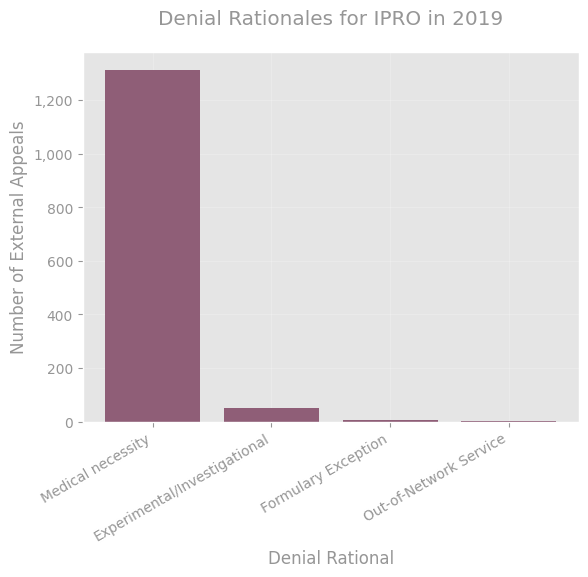

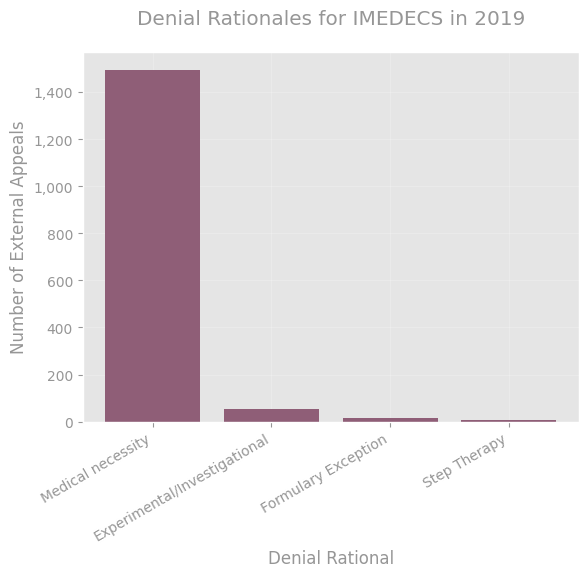

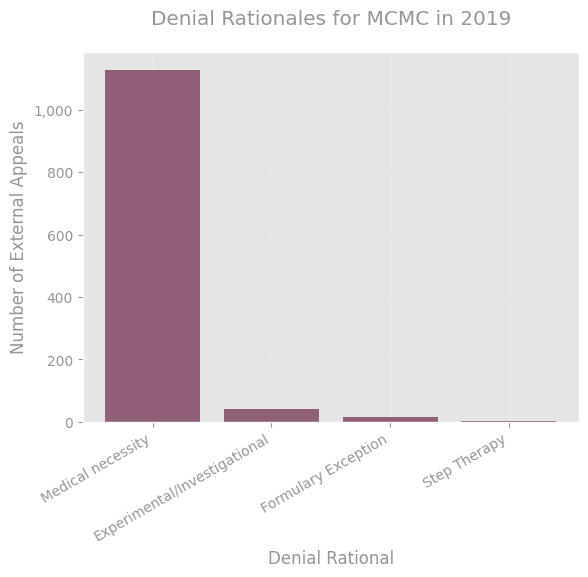

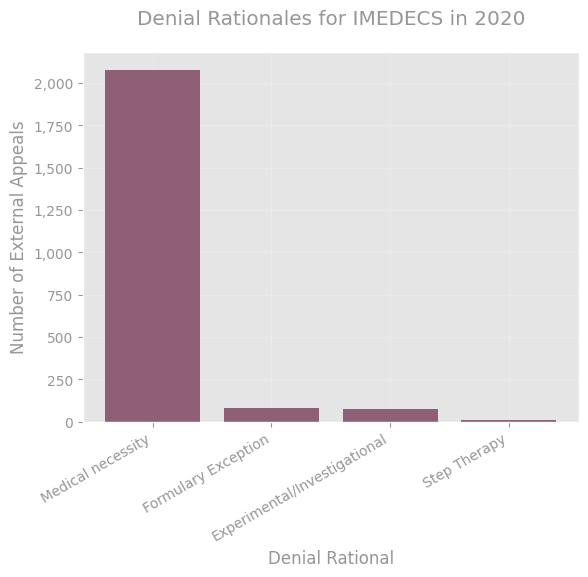

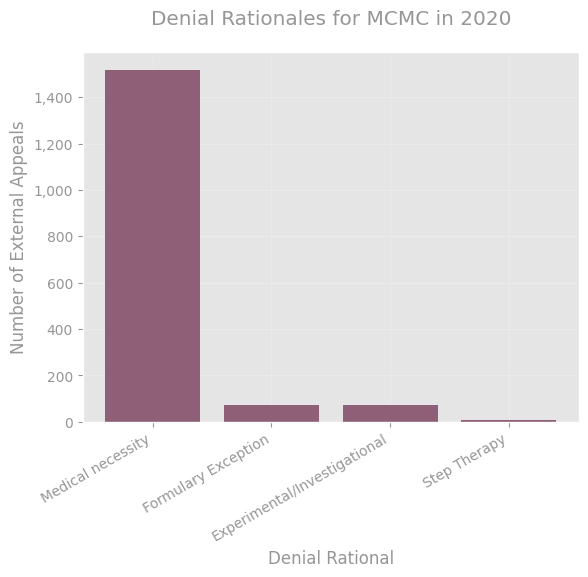

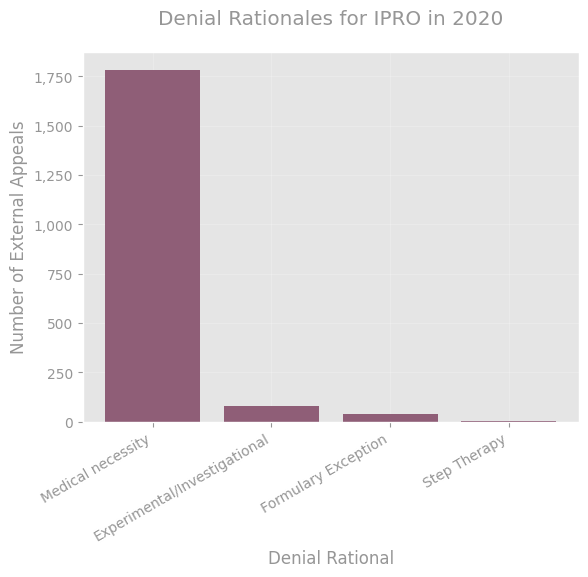

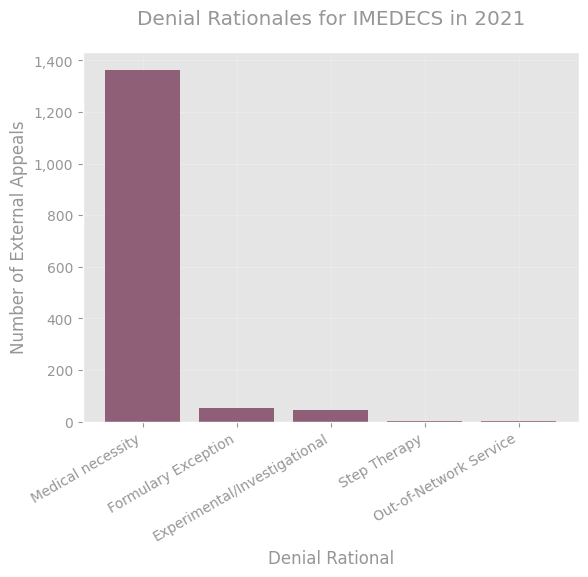

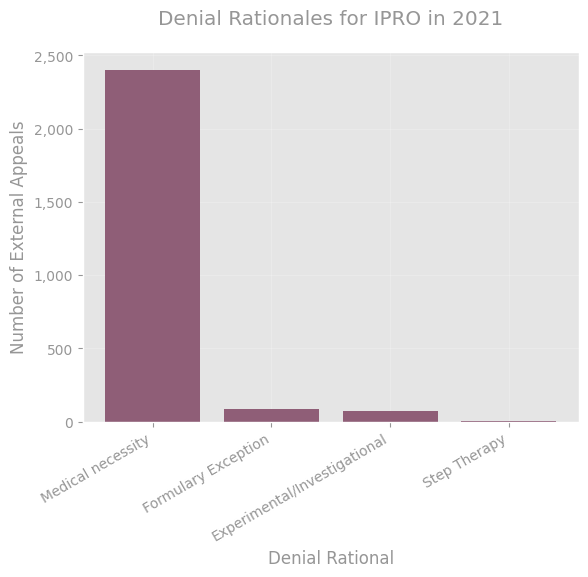

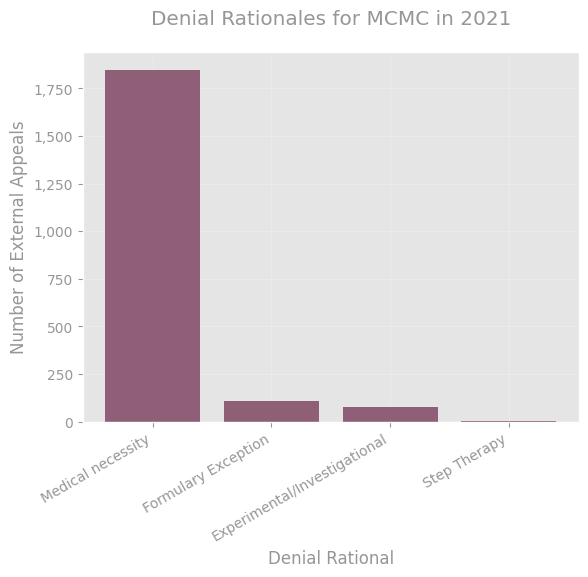

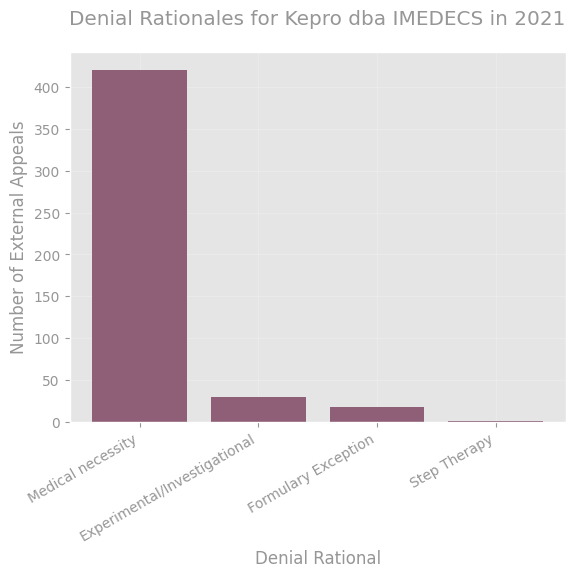

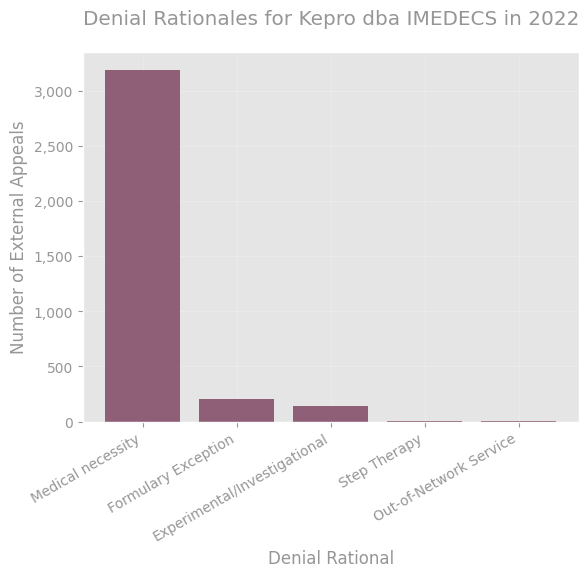

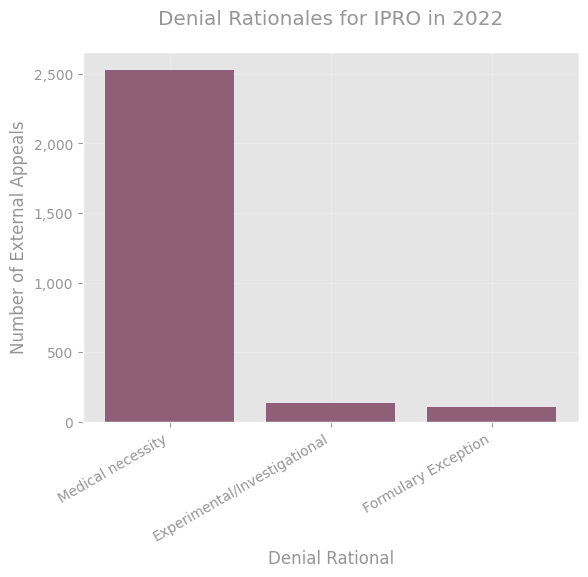

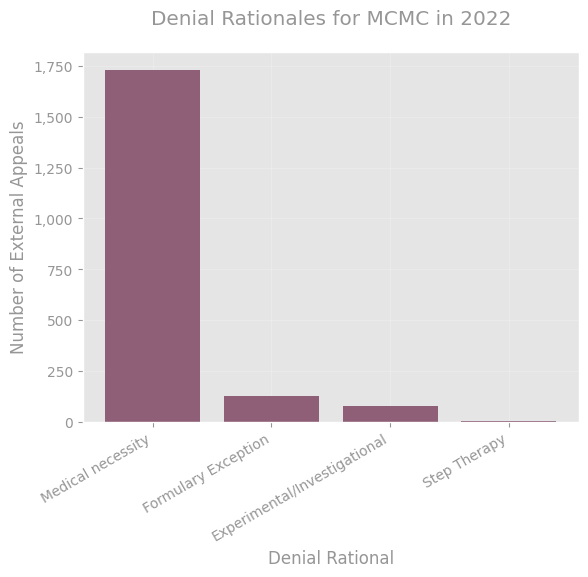

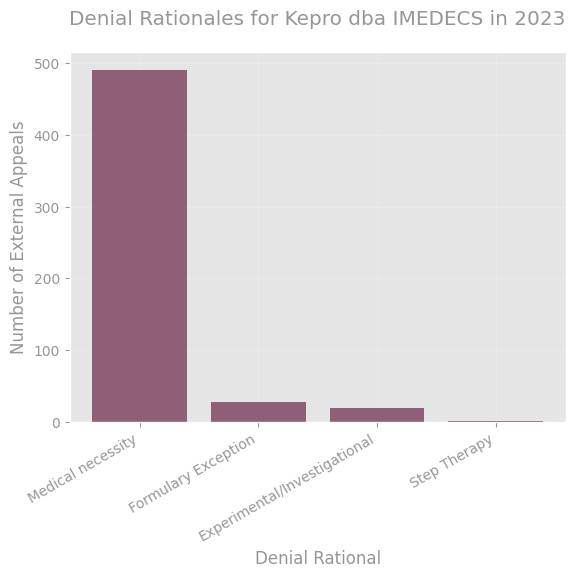

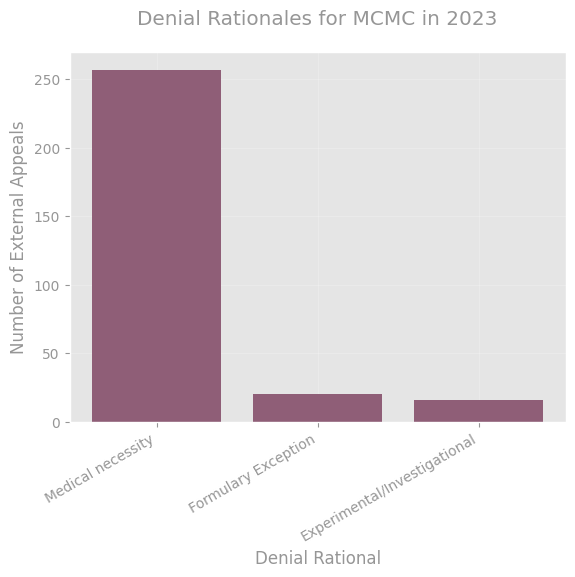

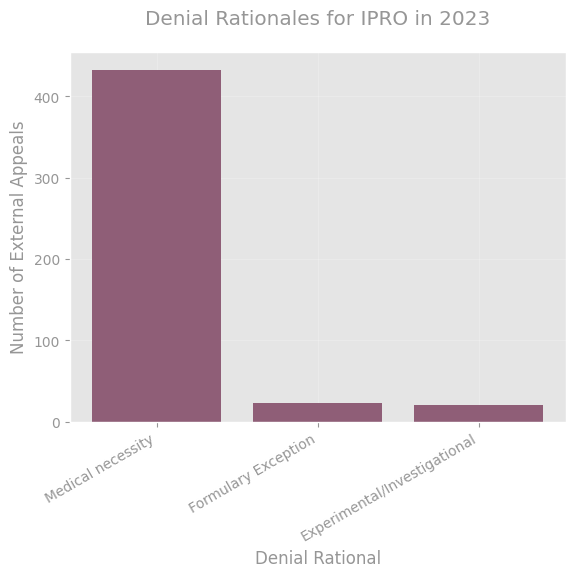

In [18]:
# Plot Distribution of Denial Rationales Handled Across Agents
for year in df["Decision Year"].unique():
    rel_df = df[df["Decision Year"] == year]
    for agent in rel_df["Agent"].unique():
        agent_year_df = rel_df[rel_df["Agent"] == agent]
        val_counts = agent_year_df["Denial Reason"].value_counts()
        title = f"Denial Rationales for {agent} in {year}"
        val_axis_label = "Number of External Appeals"
        cat_axis_label = "Denial Rational"
        bar_names, bar_vals = list(val_counts.index), val_counts.values
        plot_bar(
            bar_names,
            bar_vals,
            title=title,
            val_axis_label=val_axis_label,
            cat_axis_label=cat_axis_label,
            save_path=os.path.join(
                OUTPUT_IMAGE_DIR, f"denial_rationales_{agent}_{year}.png"
            ),
        )

It's interesting to note that that three Independent Review Organizations serving New York State have wildly different (and consistently different) complete overturn rates over the last four years.
While the average difference of about 3-6% between the agency with the highest overturn rate and the lowest may seem small, the implications for individuals whose cases are being reviewed are obviously serious.

This discrepancy also has implications for the costs of our healthcare (and who shoulders those costs). For example, suppose the ground truth here is that the review organization with the lower overturn rate (IMEDECS, which was subsumed by KEPRO) was in fact not appropriately administering reviews effectively, and were they to hand all of their cases over to either of the other organizations, those organizations would maintain their same overturn rates even with the new data (I have no evidence to back this up; this supposition is made as a thought experiment). If that were the case, the avgerage difference in overturn rate would have the effect of overturning about 445 denial decisions that would otherwise go upheld by kepro/IMEDECS, by a back of the envelope calculation. If each of these claims reduced out of pocket consumer costs by just 200 dollars (which feels highly conservative), this would amount to about 90k of wealth being inappropriately transferred from the population of average consumers fighting bills to the population of billion dollar, already highly profitable companies. See below for this rough calculation.

In [19]:
# # Back of envelope calculation:

# # Assuming the average claim being externally appealed corresponds to $200 (to be paid either by insurer, or insured). No data to back this up, but trying to make it highly conservative estimate,
# # so the back of envelope calculation airs on the side of grossly underestimating value.
# avg_claim_value = 200

# # Kepro / IMEDECS avg overturn rate over course of data timespan
# imedecs_cases = agent_decision_data["IMEDECS"]["overall"]
# kepro_cases = agent_decision_data["Kepro dba IMEDECS"]["overall"]
# kepro_imedecs_overturns = imedecs_cases["completely_overturned"] + kepro_cases["completely_overturned"]
# kepro_imedecs_external_appeals = imedecs_cases["completely_overturned"] + imedecs_cases["partially_overturned"] + imedecs_cases ["upheld"] + kepro_cases["completely_overturned"] + kepro_cases["partially_overturned"] + kepro_cases ["upheld"]
# kepro_imedecs_avg_overturn_rate = kepro_imedecs_overturns / kepro_imedecs_external_appeals

# # IPRO avg
# ipro_overturn_rate = agent_decision_data["IPRO"]["overall"]["complete_overturn_rate"]

# # MCMC avg
# mcmc_overturn_rate = agent_decision_data["MCMC"]["overall"]["complete_overturn_rate"]


# # Overturns resulting from splitting KEPRO handled appelals between IPRO/MCMC
# hypothetical_kepro_overturns = .5* kepro_imedecs_external_appeals * (ipro_overturn_rate + mcmc_overturn_rate)

# # Extra overturns one might expect
# additional_overturns = hypothetical_kepro_overturns - kepro_imedecs_overturns

# # Possible wealth retained by consumers
# wealth = additional_overturns * (200)

# print(f"Distributing {kepro_imedecs_external_appeals} external appeals submitted to KEPRO/IMEDECS from 2019 to 2023 evenly between other review agencies",
#        f"would lead to an expected {round(additional_overturns)} additional denial overturns. If each overturn corresponded to just ${avg_claim_value}",
#        f"of reduced out of pocket expense for consumers, this would amount to a total of ${round(wealth)} being returned to consumers in NY.")

#### Diagnosis breakdowns

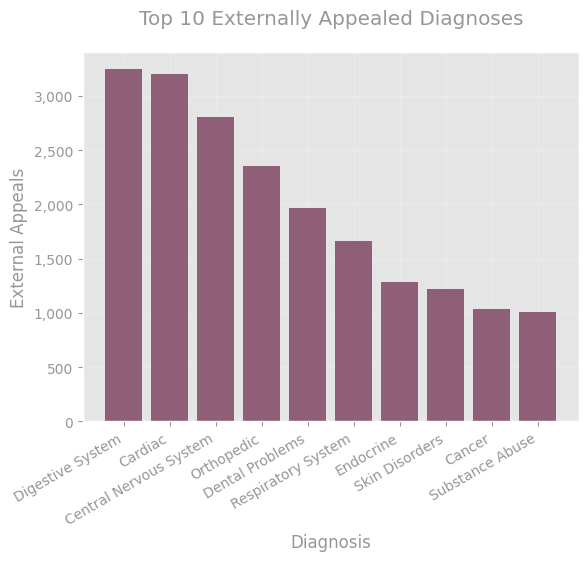

In [20]:
# Diagnosis breakdowns
n = 10
title = f"Top {n} Externally Appealed Diagnoses"
val_axis_label = "External Appeals"
cat_axis_label = "Diagnosis"
diagnosis_val_counts = df["Diagnosis"].value_counts()[:n]
bar_names, bar_vals = [
    x.strip("[").strip("]").split("/")[0] for x in list(diagnosis_val_counts.index)
], diagnosis_val_counts.values
plot_bar(
    bar_names,
    bar_vals,
    title=title,
    val_axis_label=val_axis_label,
    cat_axis_label=cat_axis_label,
    save_path=os.path.join(OUTPUT_IMAGE_DIR, "top_externally_appealed_diagnoses.png"),
)

In [21]:
diagnosis_decision_data = get_overturn_rates_by_category(
    df, cat_col="Diagnosis", by_year=True
)

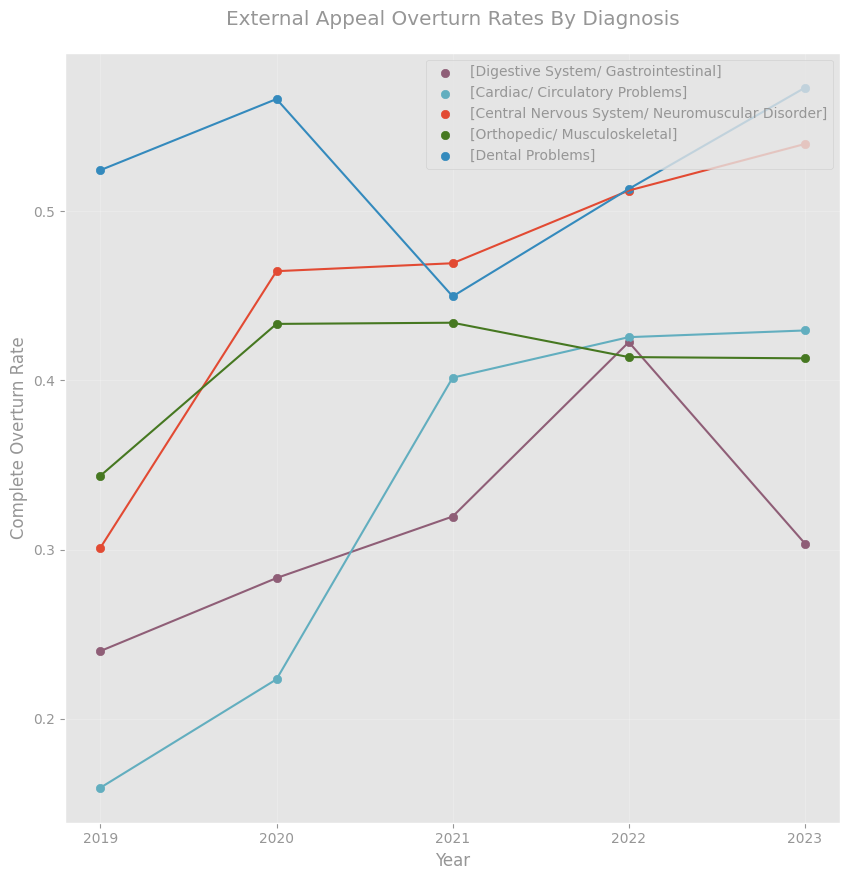

In [22]:
# Plot diagnosis decision rates over time
fig, ax = plt.subplots(figsize=(10, 10))
x = list(df["Decision Year"].unique())
ax.set_title("External Appeal Overturn Rates By Diagnosis")
ax.set_ylabel("Complete Overturn Rate")
ax.set_xlabel("Year")
dates = np.asarray(x).astype(str)
for diagnosis in diagnosis_val_counts[:5].keys():
    timeseries = []
    for year in x:
        if diagnosis_decision_data[diagnosis].get(year, None):
            timeseries.append(
                diagnosis_decision_data[diagnosis][year]["complete_overturn_rate"]
            )
        else:
            timeseries.append(None)
    ax.scatter(dates, timeseries, label=diagnosis)
    ax.plot(dates, timeseries)
ax.legend()
save_path = os.path.join(
    OUTPUT_IMAGE_DIR, "external_appeal_overturn_rates_by_diganosis.png"
)
plt.savefig(save_path, transparent=True, bbox_inches="tight")
plt.show()

#### Breakdown by Age

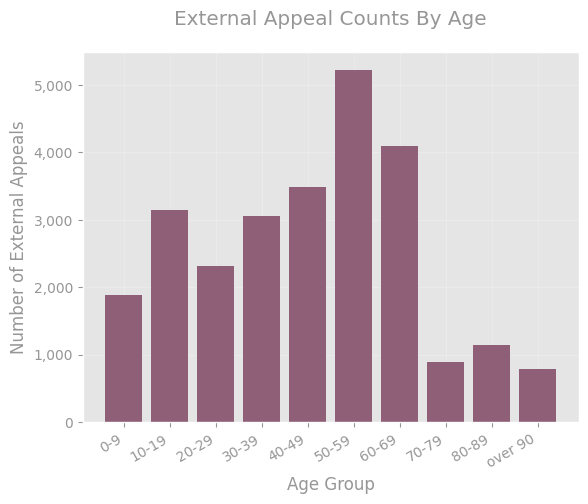

In [23]:
appeals_by_age = df["Age Range"].value_counts()
bar_names, bar_vals = list(appeals_by_age.index), appeals_by_age.values
sort_order = np.argsort(bar_names)
bar_names = [bar_names[x] for x in sort_order]
bar_vals = [bar_vals[x] for x in sort_order]
title = "External Appeal Counts By Age"
val_axis_label = "Number of External Appeals"
cat_axis_label = "Age Group"
plot_bar(
    bar_names,
    bar_vals,
    title=title,
    val_axis_label=val_axis_label,
    cat_axis_label=cat_axis_label,
    save_path=os.path.join(OUTPUT_IMAGE_DIR, "external_appeal_counts_by_age.png"),
)
# May or may not coincide with claims counts by age? Looks not skewed enough toward elderly for that to be true

In [24]:
# Success rate by age
age_decision_data = get_overturn_rates_by_category(
    df, cat_col="Age Range", by_year=True
)

# Sorted (for plotting)
age_keys = list(age_decision_data.keys())
age_keys.sort()
sorted_age_decision_data = {key: age_decision_data[key] for key in age_keys}

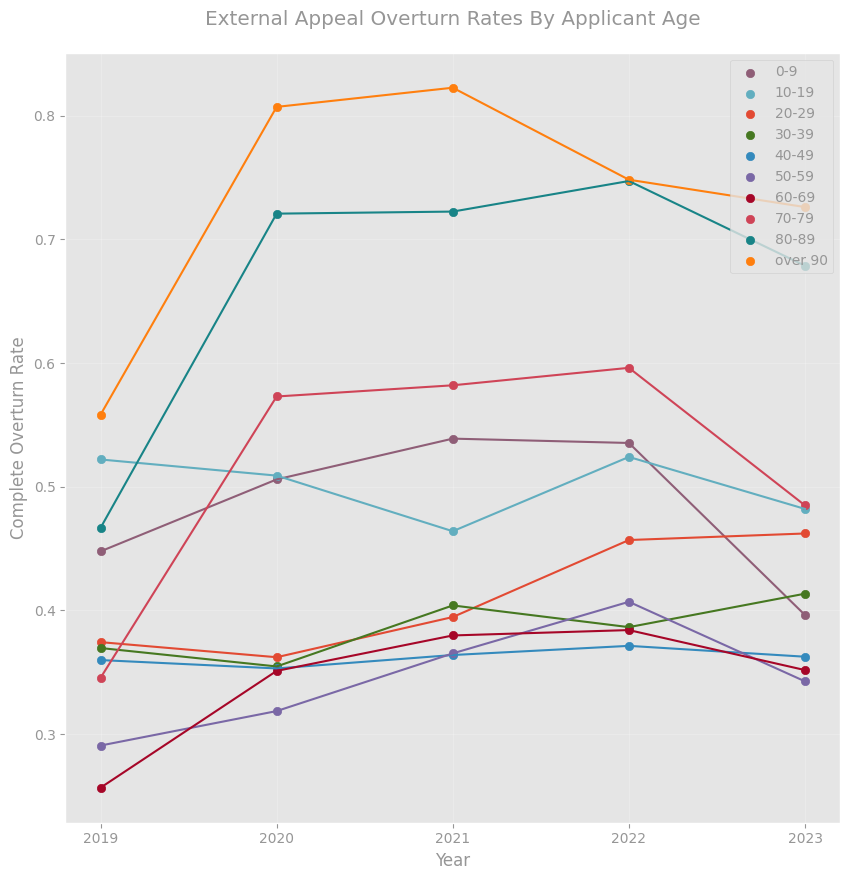

In [25]:
# Plot agent decision rates over time
fig, ax = plt.subplots(figsize=(10, 10))
x = list(df["Decision Year"].unique())
ax.set_title("External Appeal Overturn Rates By Applicant Age")
ax.set_ylabel("Complete Overturn Rate")
ax.set_xlabel("Year")
dates = np.asarray(x).astype(str)
for age in sorted_age_decision_data:
    age_timeseries = []
    for year in x:
        if age_decision_data[age].get(year, None):
            age_timeseries.append(
                age_decision_data[age][year]["complete_overturn_rate"]
            )
        else:
            age_timeseries.append(None)
    ax.scatter(dates, age_timeseries, label=age)
    ax.plot(dates, age_timeseries)
ax.legend()
save_path = os.path.join(OUTPUT_IMAGE_DIR, "external_appeal_overturn_rates_by_age.png")
plt.savefig(save_path, transparent=True, bbox_inches="tight")
plt.show()

#### Breakdown By Gender

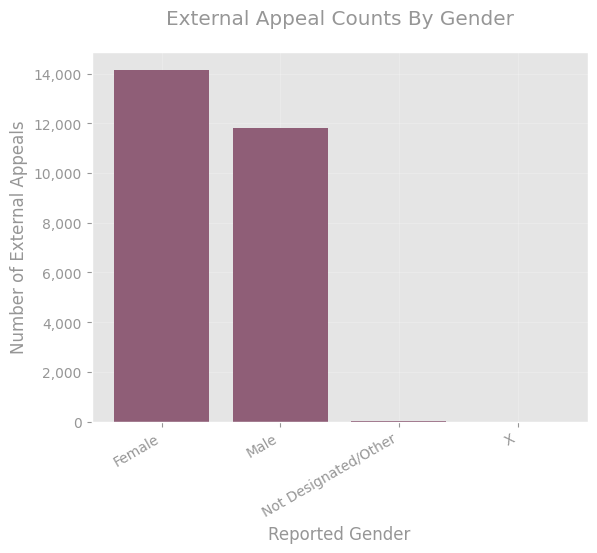

In [26]:
appeals_by_age = df["Gender"].value_counts()
bar_names, bar_vals = list(appeals_by_age.index), appeals_by_age.values
title = "External Appeal Counts By Gender"
val_axis_label = "Number of External Appeals"
cat_axis_label = "Reported Gender"
plot_bar(
    bar_names,
    bar_vals,
    title=title,
    val_axis_label=val_axis_label,
    cat_axis_label=cat_axis_label,
    save_path=os.path.join(OUTPUT_IMAGE_DIR, "external_appeal_counts_by_gender.png"),
)

In [27]:
# Success rate by gender
gender_decision_data = get_overturn_rates_by_category(
    df, cat_col="Gender", by_year=True
)

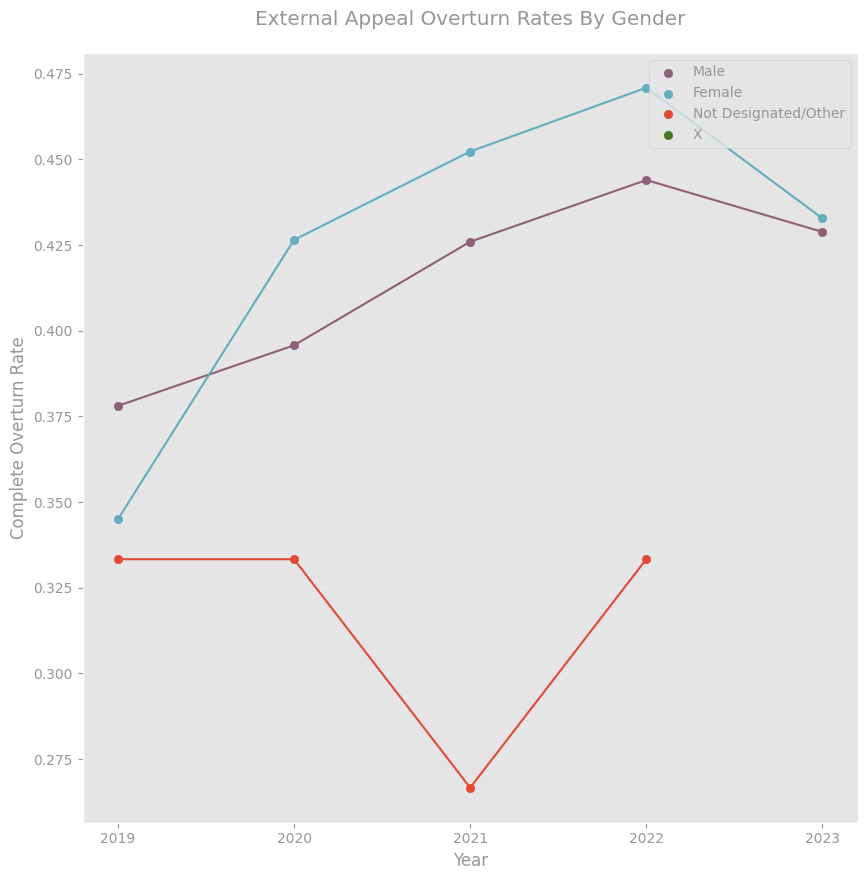

In [28]:
# Plot gender decision rates over time
fig, ax = plt.subplots(figsize=(10, 10))
x = list(df["Decision Year"].unique())
ax.set_title("External Appeal Overturn Rates By Gender")
ax.set_ylabel("Complete Overturn Rate")
ax.set_xlabel("Year")
dates = np.asarray(x).astype(str)
for age in gender_decision_data:
    age_timeseries = []
    for year in x:
        if gender_decision_data[age].get(year, None):
            age_timeseries.append(
                gender_decision_data[age][year]["complete_overturn_rate"]
            )
        else:
            age_timeseries.append(None)
    ax.scatter(dates, age_timeseries, label=age)
    ax.plot(dates, age_timeseries)
ax.legend()
save_path = os.path.join(
    OUTPUT_IMAGE_DIR, "external_appeal_overturn_rates_by_gender.png"
)
plt.savefig(save_path, transparent=True, bbox_inches="tight")
plt.show()

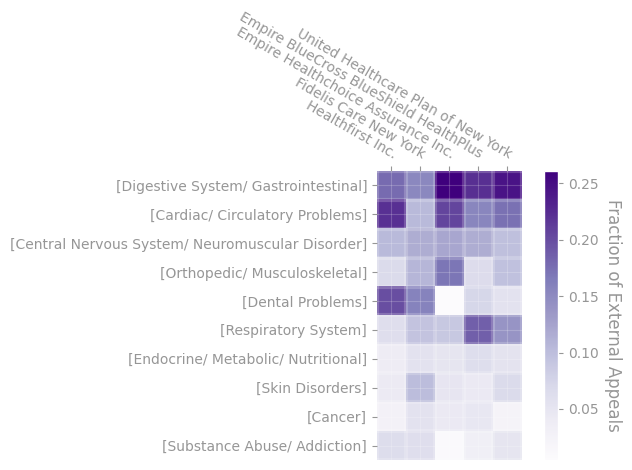

In [31]:
heatmap_from_df_cols(
    df,
    col1="Diagnosis",
    col2="Health Plan",
    top_k1=10,
    top_k2=5,
    heat_val_name="Fraction of External Appeals",
    normalize=True,
)